In [1]:
''' Asteroseismic 'first look' class '''

from __future__ import division, print_function

import copy
from tqdm import tqdm

import numpy as np
from matplotlib import pyplot as plt
from gatspy.periodic import LombScargleFast
from astropy.stats import mad_std
from scipy import interpolate
import scipy.ndimage as nd

class PowerSpectrum():
    '''
    TODO
    '''
    def __init__(self, lc):
        self.lc = lc
        self.time = lc.time * 24.0 * 3600.0
        self.flux = lc.flux * 1e6

    def power_spectrum(self, madVar=True, verbose=False):
        ''' TODO '''
        dtav = np.mean(np.diff(self.time))
        dtmed = np.median(np.diff(self.time))
        if dtmed == 0:
            dtmed = dtav
        N = len(self.time) #n-points
        df = 1.0 / dtmed / N #bw
        fmin = df
        model = LombScargleFast().fit(self.time, \
                                      self.flux)
        power = model.score_frequency_grid(fmin, df, N/2)
        freqs = fmin + df * np.arange(N/2)
        if madVar:
            var = mad_std(self.flux)**2
        else:
            var = np.std(self.flux)**2
        power /= np.sum(power)
        power *= var
        power /= df * 1e6
        if len(freqs) < len(power):
            power = power[0:len(freqs)]
        if len(freqs) > len(power):
            freqs = freqs[0:len(power)]
        self.freq = freqs * 1e6
        self.power = power
        self.bin_width = self.freq[1] - self.freq[0]
        if verbose:
            print("Frequency resolution : {}".format(self.freq[1]))
            print("Nyquist : ~".format(self.freq.max()))

    def plot_timeseries(self, ax=[]):
        ''' TODO '''
        if ax == []:
            fig, ax = plt.subplots()
        ax.plot(self.time, self.flux)
        plt.show()

    def rebin_quick(self, smoo):
        ''' TODO Write DOC strings '''
        if smoo < 1:
            return f, p
        if self.freq == []:
            self.power_spectrum()
        self.smoo = int(smoo)
        m = int(len(self.power) / self.smoo)
        self.smoo_freq = self.freq[:m*self.smoo].reshape((m,self.smoo)).mean(1)
        self.smoo_power = self.power[:m*self.smoo].reshape((m,self.smoo)).mean(1)

    def plot_power_spectrum(self, smoo=0, plog=True, ax=[]):
        ''' Plots the power spectrum '''
        if len(self.freq) < 0:
            self.power_spectrum()
        if ax == []:
            fig, ax = plt.subplots()
        ax.plot(self.freq, self.power, 'b-')
        if plog:
            ax.set_xscale('log')
            ax.set_yscale('log')
        ax.set_xlabel(r'$\rm Frequency (\rm \mu Hz)$')
        ax.set_ylabel(r'$\rm Power (\rm ppm^{2} \, \mu Hz^{-1})$')
        ax.set_xlim([self.freq.min(),self.freq.max()])
        if smoo > 0:
            self.rebin_quick(smoo)
            ax.plot(self.smoo_freq, self.smoo_power, 'k-', linewidth=4)

    def set_width(self, numax, a=0.66, b=0.88, factor=1.5):
        ''' Returns the estimated width of the mode envelope using a simple relation '''
        return a * numax**b * factor

    def get_snr(self, smoo=0, skips=50):
        ''' Gets the snr by dividing through by a background estimated from a dynamic smooth '''
        med = [np.median(self.power[np.abs(self.freq - d) < self.set_width(d, factor=1)]) for d in self.freq[::skips]]
        f = interpolate.interp1d(self.freq[::skips], med, bounds_error=False)
        med = f(self.freq)
        self.snr = self.power / med
        self.snr[:skips] = 1.0
        self.snr[-skips:] = 1.0
        if smoo > 1:
            self.snr = nd.filters.uniform_filter1d(self.snr, int(smoo))

    def plot_snr(self, ax=[], smoo=20):
        ''' Plots the SNR spectrum '''
        self.get_snr()
        if ax == []:
            fig, ax = plt.subplots()
        ax.plot(self.freq, self.snr, label='Data')
        self.get_snr(smoo=smoo)
        ax.plot(self.freq, self.snr, 'k-', lw=3, label='Smoothed Data')
        ax.set_xlabel(r'$\rm Frequency (\rm \mu Hz)$')
        ax.set_ylabel(r'$\rm SNR$')
        ax.legend(loc='best')

    def plot_echelle(self, dnu, numax, ax=[]):
        ''' TODO '''
        if ax == []:
            fig, ax = plt.subplots()
        df = self.freq[1] - self.freq[0]
        bins_per_n = int(np.round(dnu / df))
        nn = int(np.floor(len(self.snr) / bins_per_n))
        print(bins_per_n, nn, df)
        ech = self.snr[:int(bins_per_n * nn)].reshape(nn, bins_per_n)
        x = np.linspace(0, dnu, bins_per_n)
        y = np.arange(0, nn, 1) * dnu
        X, Y = np.meshgrid(x, y)
        ax.contourf(X, Y, np.log(ech/2), 200)
        ax.set_ylim([numax * 0.5, numax * 1.5])

In [7]:
from lightkurve import KeplerTargetPixelFile as ktpf
tpf = ktpf.from_archive('211416749', campaign = 5, cadence='long')
lc = tpf.to_lightcurve().normalize().remove_nans().remove_outliers().correct(windows=10).remove_outliers()

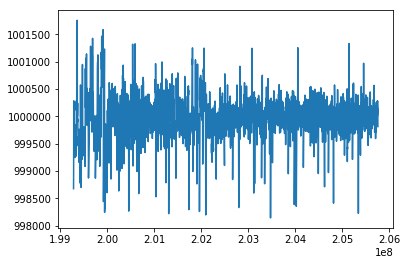

In [12]:
ps = PowerSpectrum(lc)
ps.power_spectrum()
ps.plot_timeseries()

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:65: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


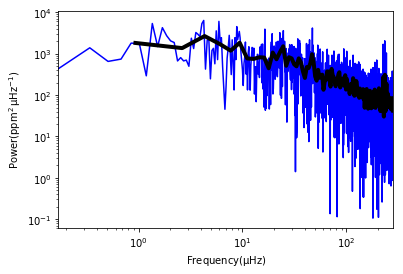

In [16]:
ps.plot_power_spectrum(smoo=10)

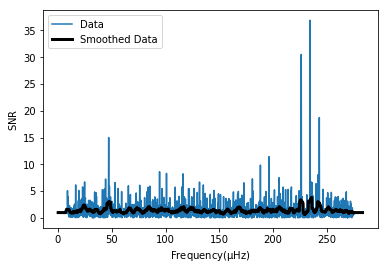

In [18]:
ps.get_snr()
ps.plot_snr()

In [20]:
numax = ps.freq[np.argmax(ps.snr)]

714 2 0.16955238595941383


AttributeError: 'NoneType' object has no attribute 'set_ylim'

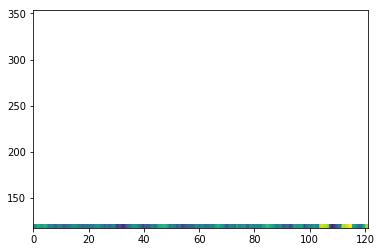

In [22]:
ax = ps.plot_echelle(ps.set_width(numax), numax)
ax.set_ylim(0., 10)

# DFM Code Test

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter

from astropy.stats import LombScargle

from lightkurve import KeplerLightCurveFile

In [2]:
target = "KIC11615890"
lc = KeplerLightCurveFile.from_archive(target, quarter=0).PDCSAP_FLUX.normalize()
for q in range(1, 17):
    lc = lc.append(KeplerLightCurveFile.from_archive(target, quarter=q).PDCSAP_FLUX.normalize())

(100, 100000)

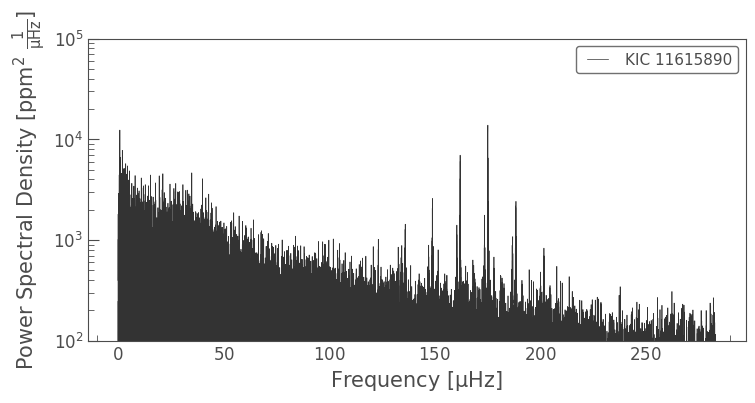

In [3]:
import astropy.units as u
lc = lc.remove_nans()
pg = lc.periodogram(freq_unit = u.microhertz)
ax = pg.plot()
ax.set_yscale('log')
ax.set_ylim(10**2, 10**5)

In [5]:
def estimate_background(x, y, log_width=0.01):
    count = np.zeros(len(x), dtype=int)
    bkg = np.zeros_like(x)
    x0 = np.log10(x[0])
    while x0 < np.log10(x[-1]):
        m = np.abs(np.log10(x) - x0) < log_width
        bkg[m] += np.median(y[m])
        count[m] += 1
        x0 += 0.5 * log_width
    return bkg / count

/usr/local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


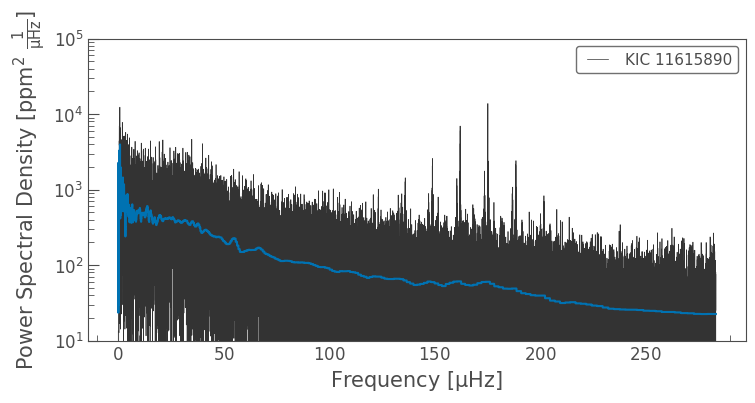

In [8]:
bkg = estimate_background(pg.frequencies.value, pg.power.value)

ax = pg.plot()
ax.set_yscale('log')
ax.set_ylim(10**1, 10**5)
ax.plot(pg.frequencies, bkg, label='background')
plt.show()

In [9]:
def find_peaks(z):
    peak_inds = (z[1:-1] > z[:-2]) * (z[1:-1] > z[2:])
    peak_inds = np.arange(1, len(z)-1)[peak_inds]
    peak_inds = peak_inds[np.argsort(z[peak_inds])][::-1]
    return peak_inds

# Smooth the power spectrum to find nu_max
df = pg.frequency_spacing.value
smoothed_ps = gaussian_filter(pg.power.value / bkg, 10 / df)
peak_freqs = pg.frequencies.value[find_peaks(smoothed_ps)]
nu_max = peak_freqs[peak_freqs > 5][0]

In [12]:
factor = np.max(pg.power.value / bkg) / np.max(smoothed_ps)

102.05561411609827

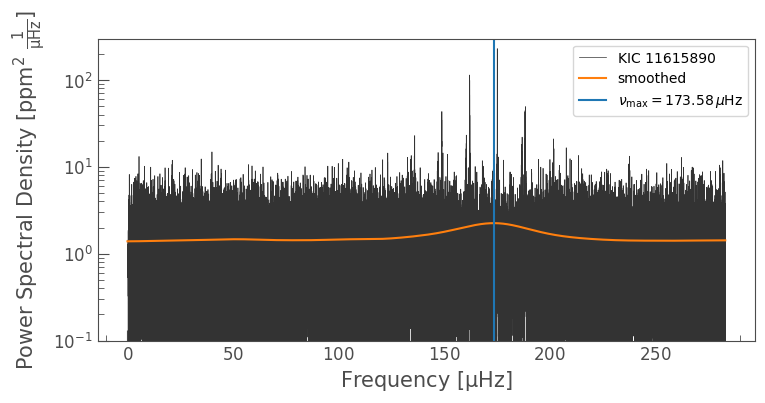

In [28]:
pg_bc = pg / bkg
ax = pg_bc.plot()
ax.set_yscale('log')
ax.plot(pg.frequencies, smoothed_ps, label='smoothed', color='C1')
ax.axvline(nu_max,  label="$\\nu_\mathrm{{max}} = {0:.2f}\,\mu\mathrm{{Hz}}$".format(nu_max))
ax.set_ylim(1e-1, 3e2)
ax.legend()

In [17]:
def next_pow_two(n):
    i = 1
    while i < n:
        i = i << 1
    return i

def acor_function(x):
    x = np.atleast_1d(x)
    n = next_pow_two(len(x))
    f = np.fft.fft(x - np.mean(x), n=2*n)
    acf = np.fft.ifft(f * np.conjugate(f))[:len(x)].real
    acf /= acf[0]
    return acf

# And the autocorrelation function of a lightly smoothed power spectrum
acor = acor_function(gaussian_filter(pg_bc.power.value, 0.5 / df))
lags = df*np.arange(len(acor))
acor = acor[lags < 30]
lags = lags[lags < 30]

# Expected delta_nu: Stello et al (2009)
dnu_expected = 0.263 * nu_max ** 0.772
peak_lags = lags[find_peaks(acor)]
delta_nu = peak_lags[np.argmin(np.abs(peak_lags - dnu_expected))]

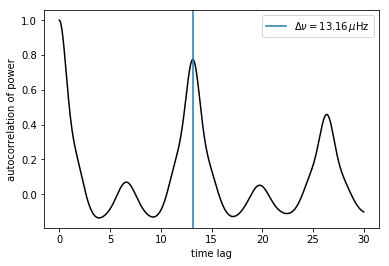

In [18]:
plt.plot(lags, acor, 'k')
plt.axvline(delta_nu, label="$\Delta \\nu = {0:.2f}\,\mu\mathrm{{Hz}}$".format(delta_nu))
plt.xlabel('time lag')
plt.ylabel('autocorrelation of power')
plt.legend()

In [19]:
peak_lags

array([13.15692739, 26.34606269,  6.60261962, 19.74344307])

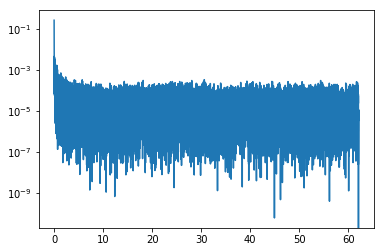

In [29]:
from astropy.stats import LombScargle
ls = LombScargle(pg.frequencies, pg.power)
ff, pp = ls.autopower(samples_per_peak=10, nyquist_factor=1)
plt.semilogy(ff, pp)

In [31]:
print(1/ff[np.argmax(pp)])

5663.920359290309 uHz
